In [326]:
#importing all the essential libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
import nltk.stem
import sys
import scipy as sp
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import string
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge,Lasso
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import re
%matplotlib inline

In [327]:
#reading data
data=pd.read_csv("winemag-data-130k-v2.csv")

In [328]:
#finding the no. of missing values in each column of the data
data.isna().sum()

Unnamed: 0                   0
country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

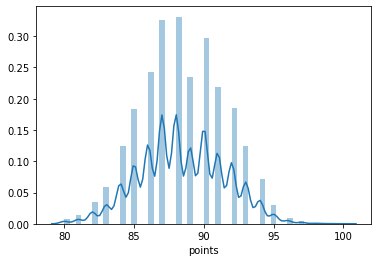

In [329]:
#checking the distribution of points for regression analysis
points=sns.distplot(data.points)

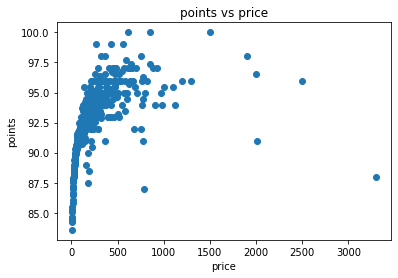

In [330]:
#checking the relation of points and price
pp=data.groupby(['price'],as_index=False).agg({'points':'mean'})
plt.scatter(pp.price,pp.points)
plt.title("points vs price")
plt.xlabel("price")
plt.ylabel("points")
plt.savefig("pp")

In [331]:
#finding the country for each winery and creating a dictionary
data.country.fillna("None",inplace=True)
data.province.fillna("None",inplace=True)
data.taster_name.fillna("None",inplace=True)
wineries=(list(data.winery.unique()))
i=0
wcp1={}
for j in range(data.shape[0]) :
    winery=data.iloc[j].winery
    if winery in wcp1 :
        continue
    elif data.iloc[j].country!="None"  :
        wcp1[winery]=str(data.iloc[j].country) + "-" + str(data.iloc[j].province)
        i+=1
    if i==len(wineries) :
        break

In [332]:
#imputing missing country/province values
for i in range(data.shape[0]) :
    if data.iloc[i].country=='None' and data.iloc[i].winery in wcp1 :
        data.at[i,'country']=wcp1[data.iloc[i].winery].split("-")[0]
        data.at[i,'province']=wcp1[data.iloc[i].winery].split("-")[1]

In [333]:
#imputing taster_name by the most common taster for that country
d1={}
for country in data.country.unique() :
    if country not in d1 :
        if data[data.country==country].taster_name.value_counts().idxmax()!='None':
            d1[country]=data[data.country==country].taster_name.value_counts().idxmax()
        else :
            d1[country]=data[data.country==country].taster_name.value_counts().index[1]
for i in range(data.shape[0]) :
    if data.iloc[i].taster_name=='None' :
        data.at[i,'taster_name']=d1[data.iloc[i].country]

In [334]:
#replcing the only missing variety by the most common variety by 'Carmen' winery in 'Maipo Valley'
data.at[86909,'variety']=data[(data.winery=='Carmen') & (data.province=='Maipo Valley')].variety.value_counts().idxmax()

In [335]:
target=data["points"]

In [336]:
#creating a dataframe to contain all features except description
feature_data=data[['country','province','variety','price','taster_name']]
#one hot encoding the categorical variables for linear models.
feature_data=pd.get_dummies(feature_data)
#fetching the original column for tree model
feature_data['country']=data['country']
feature_data['province']=data['province']
feature_data['variety']=data['variety']
feature_data['taster_name']=data['taster_name']
feature_data['description']=data['description']
feature_data['winery']=data['winery']

In [187]:
#using 15% of the entire data as test data
train_x,test_x,train_y,test_y=train_test_split(feature_data,target,test_size=0.15)

In [337]:
#imputing missing price by average price in training data
avg_price=train_x.price.mean()
train_x.price.fillna(avg_price,inplace=True)
test_x.price.fillna(avg_price,inplace=True)
train_x['price_2']=train_x['price']**2
test_x['price_2']=test_x['price']**2

In [338]:
#transforming squared price to have 0 mean and 1 std. deviation in train data for ridge regression
mean=train_x['price_2'].mean()
std=train_x['price_2'].std()
train_x['price_2']=(train_x['price_2']-mean)/std
test_x['price_2']=(test_x['price_2']-mean)/std

In [190]:
#extracting train and test data descriptions
train_descriptions=train_x.pop('description')
test_descriptions=test_x.pop('description')
train_descriptions=list(train_descriptions)
test_descriptions=list(test_descriptions)
#removing punctuations and digits from train description
exclude = set(string.punctuation)
exclude_int=[str(i) for i in range(10)]
for i in range(0,len(train_descriptions)) :
    train_descriptions[i]="".join([c for c in train_descriptions[i] if c not in exclude])
    train_descriptions[i]="".join([c for c in train_descriptions[i] if c not in exclude_int])
    train_descriptions[i]=train_descriptions[i].lower()
#removing punctuations and digits from test description
for i in range(0,len(test_descriptions)) :
    test_descriptions[i]="".join([c for c in test_descriptions[i] if c not in exclude])
    test_descriptions[i]="".join([c for c in test_descriptions[i] if c not in exclude_int])
    test_descriptions[i]=test_descriptions[i].lower()

In [191]:
#using TF-IDF vectorizer to extract important words from train description and creating features.
lemmatizer = WordNetLemmatizer()
english_stemmer=nltk.stem.SnowballStemmer('english')
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer,self).build_analyzer()
        #return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))
        return lambda doc: (lemmatizer.lemmatize(w) for w in analyzer(doc))
vectorizer = StemmedTfidfVectorizer(min_df=50, max_df=0.8,stop_words='english',decode_error='ignore')
train_text_features=vectorizer.fit_transform(train_descriptions).toarray()
train_text_features.shape

(110475, 3267)

In [192]:
#using the TF-IDF vectorizer to transform test descriptions into word features
test_text_features=vectorizer.transform(test_descriptions).toarray()
test_text_features.shape

(19496, 3267)

In [193]:
#creating separate dataframes for linear and tree model
train_x_label_encode=pd.DataFrame()
test_x_label_encode=pd.DataFrame()
train_x_onehot_encode=pd.DataFrame()
test_x_onehot_encode=pd.DataFrame()
for column in train_x.columns :
    if column in ['country','province','variety','taster_name','price','winery']:
        train_x_label_encode[column]=train_x[column]
        test_x_label_encode[column]=test_x[column]
    else :
        train_x_onehot_encode[column]=train_x[column]
        test_x_onehot_encode[column]=test_x[column]       

In [194]:
#merging data features and text features
train_x_tree=np.append(train_text_features,np.array(train_x_label_encode),1)
test_x_tree=np.append(test_text_features,np.array(test_x_label_encode),1)
train_x_linear=np.append(train_text_features,np.array(train_x_onehot_encode),1)
test_x_linear=np.append(test_text_features,np.array(test_x_onehot_encode),1)

In [195]:
#creating cross validation set from training data by selecting 20% data.
x_train_tree,x_cv_tree,y_train_tree,y_cv_tree=train_test_split(train_x_tree,
                                                train_y,test_size=0.2)
x_train_linear,x_cv_linear,y_train_linear,y_cv_linear=train_test_split(
    train_x_linear,train_y,test_size=0.2)

In [196]:
#tuning regularization parameter for ridge regression using cross-validation
alpha_list=np.linspace(0.1,1,10)
rmse_alpha=[]
rmse_alpha_train=[]
for a in alpha_list :
    ridge_temp=Ridge(alpha=a)
    ridge_temp.fit(x_train_linear,y_train_linear)
    y_temp=ridge_temp.predict(x_cv_linear)
    acc=0
    for i in range(y_temp.shape[0]) :
        acc+=(y_temp[i]-y_cv_linear.iloc[i])**2
    rmse_temp=np.sqrt(acc/y_temp.shape[0])
    rmse_alpha.append(rmse_temp)
    y_temp_linear=ridge_temp.predict(x_train_linear)
    acc=0
    for i in range(y_temp_linear.shape[0]) :
        acc+=(y_temp_linear[i]-y_train_linear.iloc[i])**2
    rmse_temp=np.sqrt(acc/y_temp_linear.shape[0])
    rmse_alpha_train.append(rmse_temp)

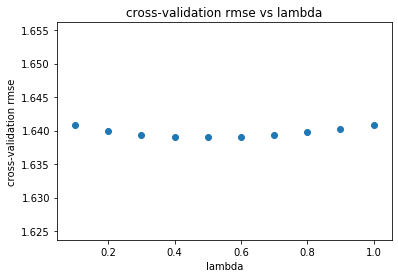

In [197]:
plt.scatter(alpha_list,rmse_alpha)
plt.title("cross-validation rmse vs lambda")
plt.xlabel("lambda")
plt.ylabel("cross-validation rmse")
plt.savefig("alpha-cross-validation")

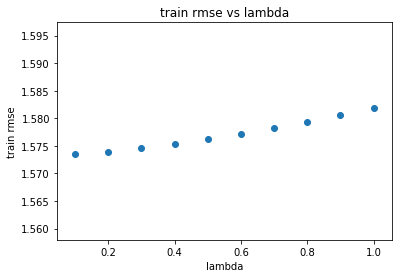

In [198]:
plt.scatter(alpha_list,rmse_alpha_train)
plt.title("train rmse vs lambda")
plt.xlabel("lambda")
plt.ylabel("train rmse")
plt.savefig("alpha-train")

In [199]:
#final ridge model with lambda=0.5
ridge_final=Ridge(alpha=0.5)
ridge_final.fit(train_x_linear,train_y)
y_pred_ridge_train=ridge_final.predict(train_x_linear)
#calculating rmse for train data
acc=0
for i in range(y_pred_ridge_train.shape[0]) :
    acc+=(y_pred_ridge_train[i]-train_y.iloc[i])**2
rmse_ridge_train=np.sqrt(acc/y_pred_ridge_train.shape[0])
print("rmse on train data - ", rmse_ridge_train)
y_pred_ridge=ridge_final.predict(test_x_linear)
#calculating rmse for test data
acc=0
for i in range(y_pred_ridge.shape[0]) :
    acc+=(y_pred_ridge[i]-test_y.iloc[i])**2
rmse_ridge_test=np.sqrt(acc/y_pred_ridge.shape[0])
print("rmse on test data - ", rmse_ridge_test)

rmse on train data -  1.580489383210802
rmse on test data -  1.6587275574045603


In [258]:
#tuning learning_rate parameter for gradient boosting regression using cross-validation
learning_rate_list=[0.2,0.4,0.6,0.8,1]
rmse_learning_rate=[]
for lr in learning_rate_list :
    cat_temp=CatBoostRegressor(num_trees=350,learning_rate=lr,
                cat_features=[3268,3269,3270,3271,3272],silent=True)
    cat_temp.fit(x_train_tree,y_train_tree,verbose=False)
    y_temp=cat_temp.predict(x_cv_tree)
    acc=0
    for i in range(y_temp.shape[0]) :
        acc+=(y_temp[i]-y_cv_tree.iloc[i])**2
    rmse_temp=np.sqrt(acc/y_temp.shape[0])
    rmse_learning_rate.append(rmse_temp)

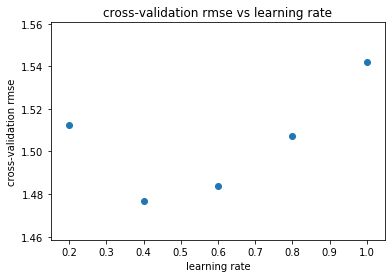

In [213]:
plt.scatter(learning_rate_list,rmse_learning_rate)
plt.title("cross-validation rmse vs learning rate")
plt.xlabel("learning rate")
plt.ylabel("cross-validation rmse")
plt.savefig("lr-train")

In [257]:
#tuning max_depth parameter for gradient boosting regression using cross-validation
max_depth_list=[2,4,6,8]
rmse_max_depth=[]
for md in max_depth_list :
    cat_temp=CatBoostRegressor(num_trees=350,learning_rate=0.4,max_depth=md,cat_features=[3268,3269,3270,3271,3272],silent=True)
    cat_temp.fit(x_train_tree,y_train_tree,verbose=False)
    y_temp=cat_temp.predict(x_cv_tree)
    acc=0
    for i in range(y_temp.shape[0]) :
        acc+=(y_temp[i]-y_cv_tree.iloc[i])**2
    rmse_temp=np.sqrt(acc/y_temp.shape[0])
    rmse_max_depth.append(rmse_temp)

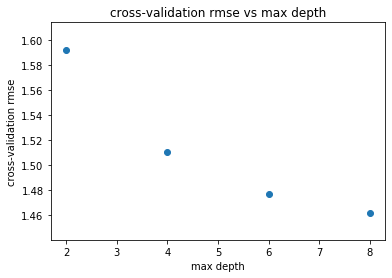

In [218]:
plt.scatter(max_depth_list,rmse_max_depth)
plt.title("cross-validation rmse vs max depth")
plt.xlabel("max depth")
plt.ylabel("cross-validation rmse")
plt.savefig("md-train")

In [255]:
#final model with learning_rate = 0.4 and max_depth = 8
cat_boost_final=CatBoostRegressor(num_trees=350,learning_rate=0.4,max_depth=8,cat_features=[3268,3269,3270,3271,3272],silent=True)
cat_boost_final.fit(train_x_tree,train_y,verbose=False)
y_pred_cat_train=cat_boost_final.predict(train_x_tree)
#calculating rmse for train data
acc=0
for i in range(y_pred_cat_train.shape[0]) :
    acc+=(y_pred_cat_train[i]-train_y.iloc[i])**2
rmse_cat_train=np.sqrt(acc/y_pred_cat_train.shape[0])
print("rmse on train data - ", rmse_cat_train)
y_pred_cat=cat_boost_final.predict(test_x_tree)
#calculating rmse for test data
acc=0
for i in range(y_pred_cat.shape[0]) :
    acc+=(y_pred_cat[i]-test_y.iloc[i])**2
rmse_cat_test=np.sqrt(acc/y_pred_cat.shape[0])
print("rmse on test data - ", rmse_cat_test)
print("rmse on train data -  1.2528776242396162")
print("rmse on test data -  1.4344652692837343")

rmse on train data -  1.2528776242396162
rmse on test data -  1.4344652692837343


In [251]:
#getting feature importance
cat_boost_final.get_feature_importance(prettified=True)[0:10]

,Feature Id,Importances
0,3267,22.453273
1,3271,7.072816
2,3272,6.889806
3,3268,2.479912
4,868,2.195597
5,3269,1.857122
6,2388,1.690681
7,1114,1.570879
8,2663,1.306845
9,607,1.200430


In [291]:
#filtered the data to get Pinot Noir wines which have fruity taste(‘fruit’ keyword in description) and 
#price less than 20 dollars
pinot_noir_data=data[(data.variety=='Pinot Noir') & (data.price < 20)]
pinot_noir_data.shape

(1356, 14)

In [292]:
fruity=[]
for i in range(pinot_noir_data.shape[0]) :
    if 'fruit' in pinot_noir_data.iloc[i].description :
        fruity.append(i)
len(fruity)

550

In [293]:
fruit_data=pinot_noir_data.iloc[fruity]
fruit_data.shape

(550, 14)

In [339]:
#extracting year of wine from title. In case year is not available, I give garbage value of 0
pattern=re.compile('[1-2][0-9]{3}')
year_list=[]
for title in fruit_data.title :
    l=pattern.findall(title)
    if len(l) > 0 :
        year_list.append(int(l[0]))
    else :
        year_list.append(0)
fruit_data['year']=year_list

In [307]:
#sorting wines by year
fruit_data_sorted=fruit_data[fruit_data.year!=0].sort_values(by=['year'])

In [308]:
years=fruit_data_sorted.year.unique()[0:5]

In [312]:
#extracting most aged wines. In case multiple wines are present with same points for a particular year, 
#anyone can be recommended
wineries={}
for year in years :
    df_temp=fruit_data_sorted[fruit_data_sorted.year==year]
    d1=df_temp.sort_values(by=['points'],ascending=False)
    wineries[str(year)]=(d1.iloc[0].winery)
    if d1.shape[0]>1 :
        wineries[str(year)]=wineries[str(year)]+"-"+d1.iloc[1].winery
wineries

{'1997': 'Camelot',
 '1998': 'Schug-Bridgeview',
 '1999': 'Schug-Firesteed',
 '2000': 'Charles Krug',
 '2001': 'Sebastiani-River Road'}